In [2]:
from util.utils import load_dataset, compute_segmentation
import numpy as np
import matplotlib.pyplot as plt
from util.segmentation import kmeans_fast
from util.segmentation import color_position_features
from skimage import io
import torch
import os
import pixellib
from pixellib.semantic import semantic_segmentation

%load_ext autoreload
%autoreload 2

In [21]:
source_img_dir = './datasets/AFHQ/train/cat/'
train_img_dir = './datasets/smolAFHQ/train/img/'
train_kmeans_label_dir = './datasets/smolAFHQ/train/kmeans_label/'
train_smart_label_dir = './datasets/smolAFHQ/train/smart_label/'

source_val_img_dir = './datasets/AFHQ/val/cat/'
val_img_dir = './datasets/smolAFHQ/val/img/'
val_kmeans_label_dir = './datasets/smolAFHQ/val/kmeans_label/'
val_smart_label_dir = './datasets/smolAFHQ/val/smart_label'

source_val_wild_dir = './datasets/AFHQ/val/wild/'
val_wild_img_dir = './datasets/smolAFHQ/wild/img/'
val_wild_kmeans_label_dir = './datasets/smolAFHQ/wild/kmeans_label/'
val_wild_smart_label_dir = './datasets/smolAFHQ/wild/smart_label'

In [9]:
# load data sets
train_imgs = load_dataset(train_img_dir)
val_imgs = load_dataset(val_img_dir)
wild_imgs = load_dataset(val_wild_img_dir)

In [37]:
# image visualization functions

def print_images(*args, n=10):
    #prints the first n images of each dataset in args
    
    plt.figure(figsize=(15,60))
    for i in range(n):

        for j in range(len(args)):
            plt.subplot(n, 3, (i * 3) + j + 1)
            plt.imshow(args[j][i])
            plt.axis('off')

# k-means Clustering Method for Segmentation Maps
In this section, we experiment with the k-means clustering method to produce baseline segmentation maps. We expect the reconstruction of the original image through the SPADE architecture will produce low fidelity images since this method produces "low quality" segmentations. Here, we loosely define low quality segmentation maps, but we will rigorously define the fidelity of the reconstructed image

In [4]:
%%timeit
k = 5
scale = 255/k
np.random.seed(0)
# create segmentaions using k-means
"""
segmentations = []
num = len(tr_imgs)
# The previous jupyter notebook died on me so i started jupyter notebook in a tmux session
# it cut off at image 1457
for i in range(1457,num):                     #, img in enumerate(imgs):
    segments = compute_segmentation(tr_imgs[i], k, clustering_fn=kmeans_fast, feature_fn=color_position_features)
    #segments = scale * segments
    segmentations.append(segments.astype(np.uint8))

    # save segmentation map to ./datasets/smolAFHQ/train/label/
    io.imsave(train_img_label_dir+'000000000'+str(i)+'.png', (segments).astype(np.uint8))
    
    # Save copy of source in training folder
    io.imsave(train_img_dir+'000000000'+str(i)+'.jpg',tr_imgs[i])
"""
# Commented out the above because it's slow and the imgs have already been made

34.7 ns ± 0.528 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [4]:
"""
k = 5
maps = []
num = 20 
for i, img in enumerate(val_imgs):
    segments = compute_segmentation(img, k, clustering_fn=kmeans_fast, feature_fn=color_position_features)
    #segments = segments * scale
    maps.append(segments.astype(np.uint8))
    
    # save segmentation map to ./datasets/smolAFHQ/val/label/
    io.imsave(val_label_dir+'000000000'+str(i)+'.png', (segments).astype(np.uint8))
    
    # Save copy of source in val/img folder
    io.imsave(val_img_dir+'000000000'+str(i)+'.jpg',img)
""" 

"\nk = 5\nmaps = []\nnum = 20 \nfor i, img in enumerate(val_imgs):\n    segments = compute_segmentation(img, k, clustering_fn=kmeans_fast, feature_fn=color_position_features)\n    #segments = segments * scale\n    maps.append(segments.astype(np.uint8))\n    \n    # save segmentation map to ./datasets/smolAFHQ/val/label/\n    io.imsave(val_label_dir+'000000000'+str(i)+'.png', (segments).astype(np.uint8))\n    \n    # Save copy of source in val/img folder\n    io.imsave(val_img_dir+'000000000'+str(i)+'.jpg',img)\n"

In [5]:
"""
k = 5
wild = []
for i, img in enumerate(wild_imgs):
    segments = compute_segmentation(img, k, clustering_fn=kmeans_fast, feature_fn=color_position_features)
    wild.append(segments.astype(np.uint8))
    
    
    # save segmentation map to ./datasets/smolAFHQ/wild/label/
    io.imsave(val_wild_label_dir+'000000000'+str(i)+'.png', (segments).astype(np.uint8))
    
    # Save copy of source in wild/img folder
    io.imsave(val_wild_img_dir+'000000000'+str(i)+'.jpg',img)
"""

"\nk = 5\nwild = []\nfor i, img in enumerate(wild_imgs):\n    segments = compute_segmentation(img, k, clustering_fn=kmeans_fast, feature_fn=color_position_features)\n    wild.append(segments.astype(np.uint8))\n    \n    \n    # save segmentation map to ./datasets/smolAFHQ/wild/label/\n    io.imsave(val_wild_label_dir+'000000000'+str(i)+'.png', (segments).astype(np.uint8))\n    \n    # Save copy of source in wild/img folder\n    io.imsave(val_wild_img_dir+'000000000'+str(i)+'.jpg',img)\n"

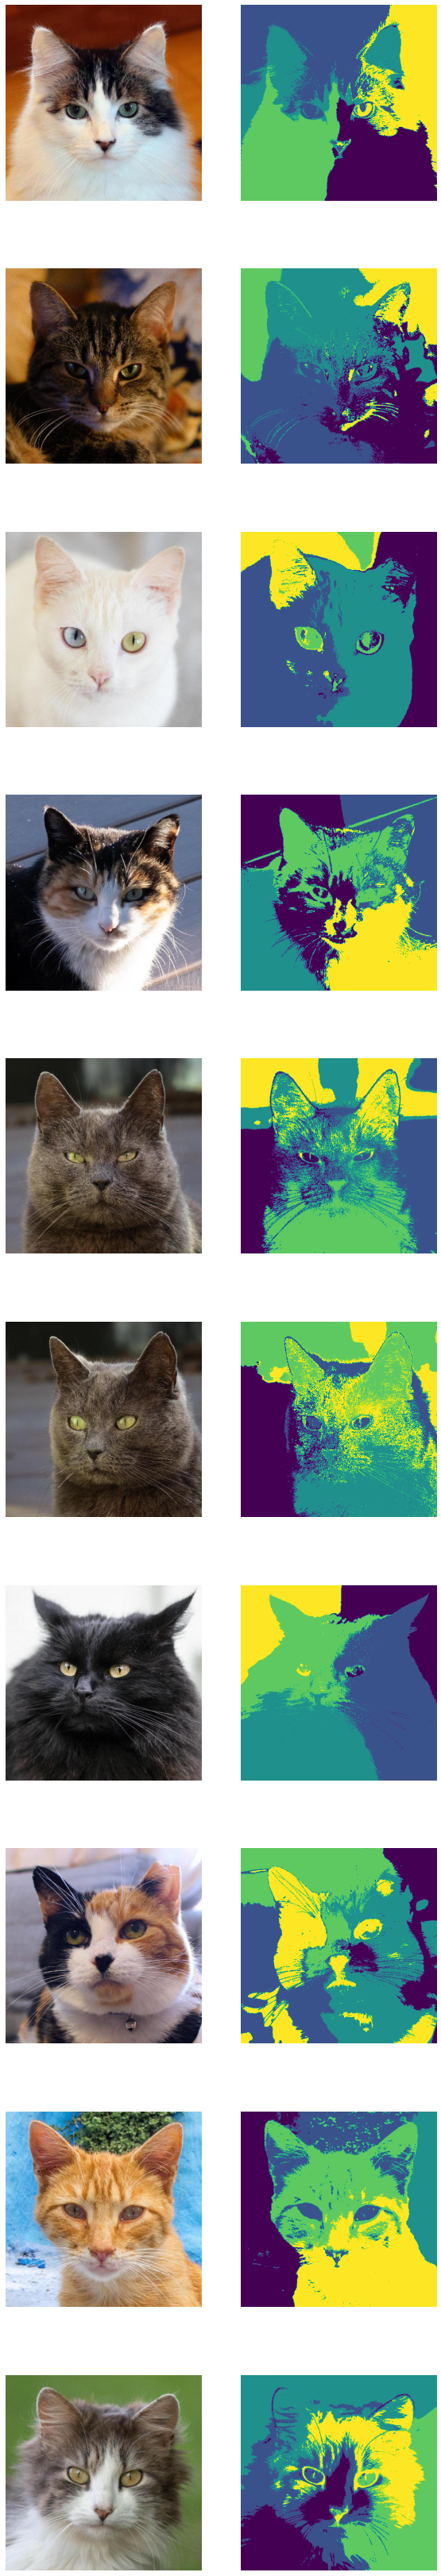

In [9]:
#N = len(imgs)
N = 10
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(val_imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(maps[i])
    plt.axis('off')

In [12]:
coco_img_dir = './datasets/coco_stuff/train_img/'
coco_lab_dir = './datasets/coco_stuff/train_label/'
coco_labels, coco_label_names = load_dataset(coco_lab_dir)

In [24]:
# Pytorch mIoU scoring
# Implementation from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
"""
eps = 1e-6
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + eps) / (union + eps) 
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()
"""

In [56]:
# Modified version of the above code
def miou(synth, inputs, eps=1e-6):
    # Inputs: NxHxW
    intersection = np.logical_and(synth,inputs).sum((1,2))
    union = np.logical_or(synth,inputs).sum((1,2))
    iou = (intersection + eps)/(union + eps)
    threshold = np.ceil(np.clip(20 *(iou-.5),0,10))/10    
    
    return threshold.mean()*100

In [24]:
path = './results/kmeansSmall/cat_val/kmeansSmall/test_latest/images/synthesized_image/'
results = load_dataset(path)
labelPath = './results/kmeansSmall/cat_val/kmeansSmall/test_latest/images/input_label/'
labels = load_dataset(labelPath)

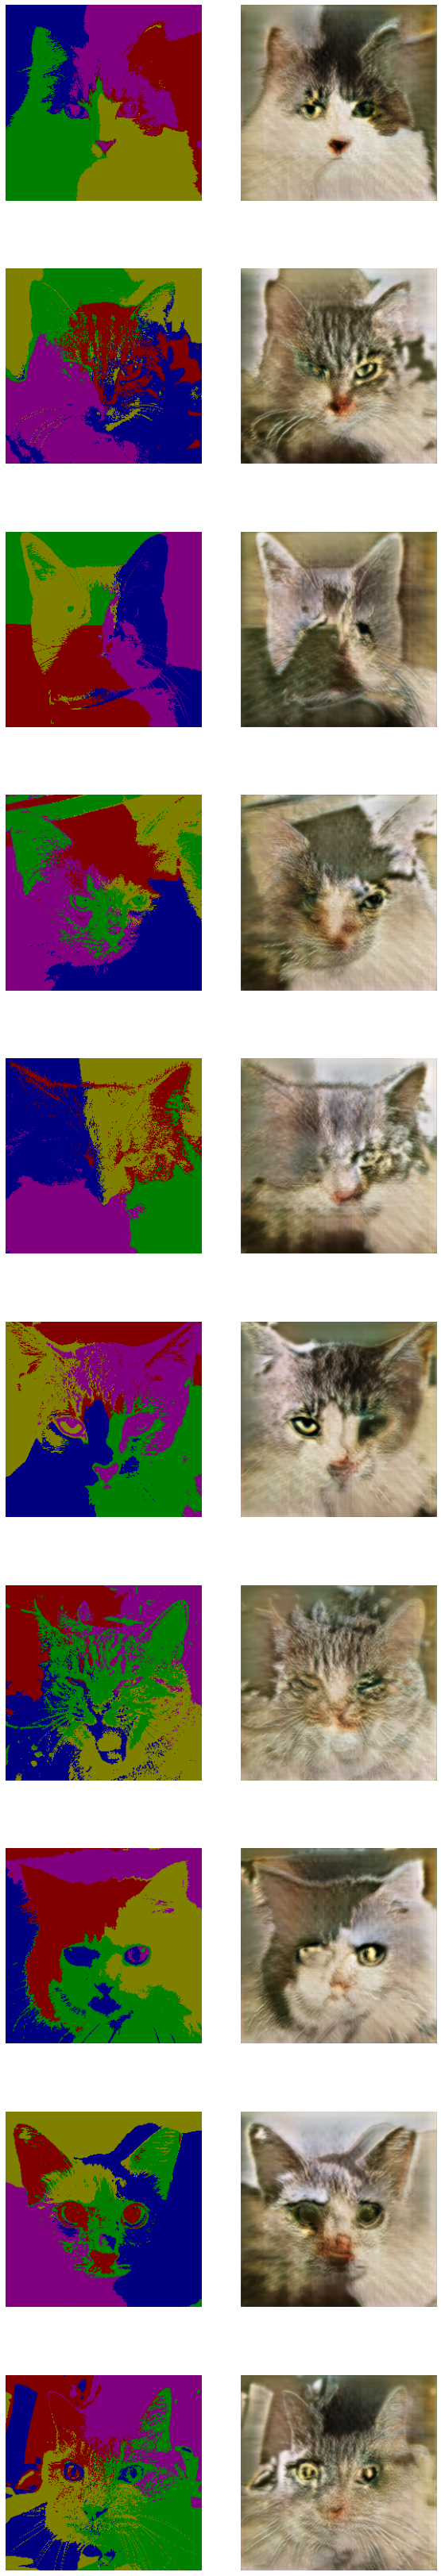

In [25]:
print_images(labels, results)

In [63]:
cats_miou_score = miou(results,labels)
print(cats_miou_score)

8.166666666666666


In [6]:
path = './results/kmeansSmall/test_latest/images/synthesized_image/'
results = load_dataset(path)
labelPath = './results/kmeansSmall/test_latest/images/input_label/'
labels = load_dataset(labelPath)

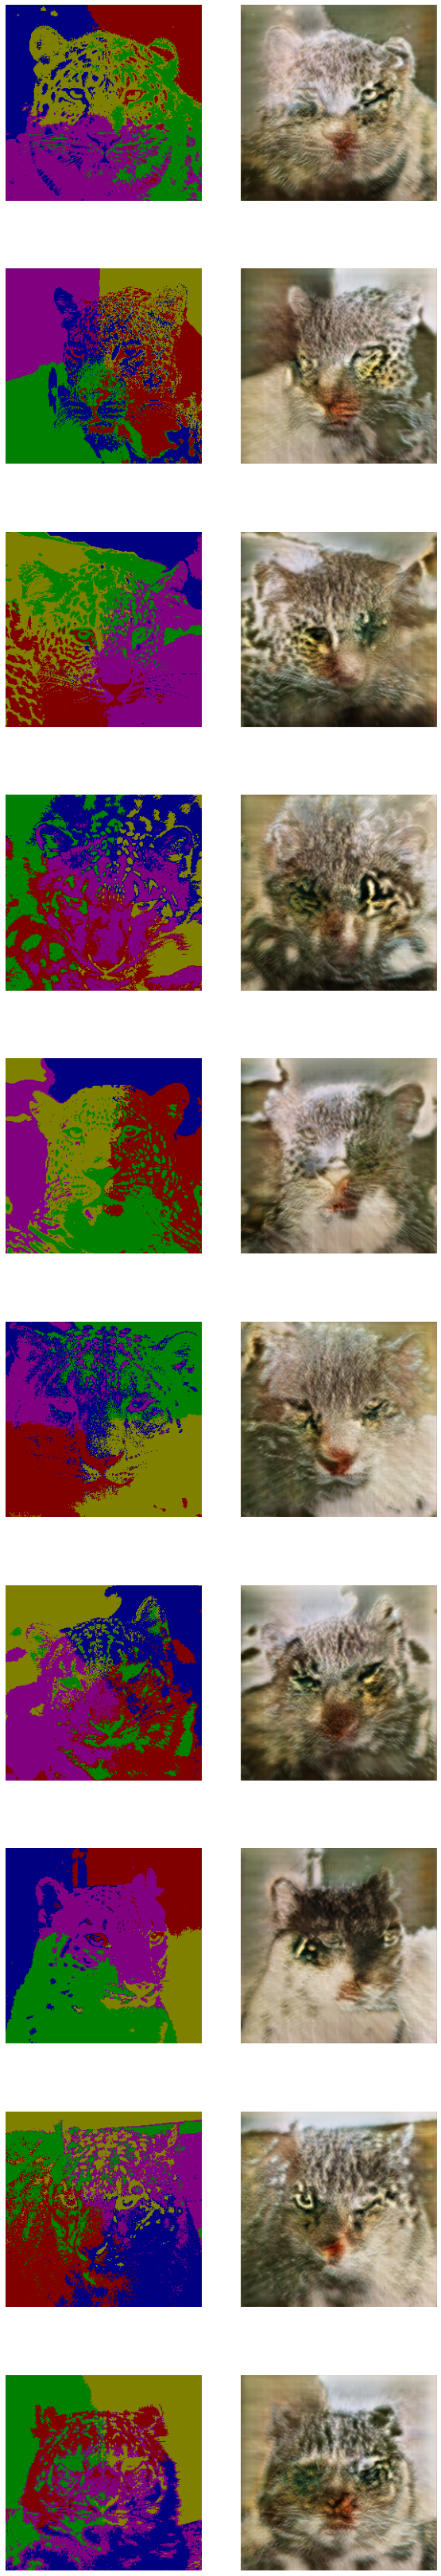

In [7]:
print_images(labels, results)

In [65]:
wild_miou_score = miou(results,labels)
print(wild_miou_score*100)

8.766666666666667


# Deep Learning Segmentation Method
In this section, we use a deep learning approach adapted from CSAILVision. This library is pretrained.

In [20]:
test_labels = load_dataset("./datasets/smolAFHQ/train/smart_label/")

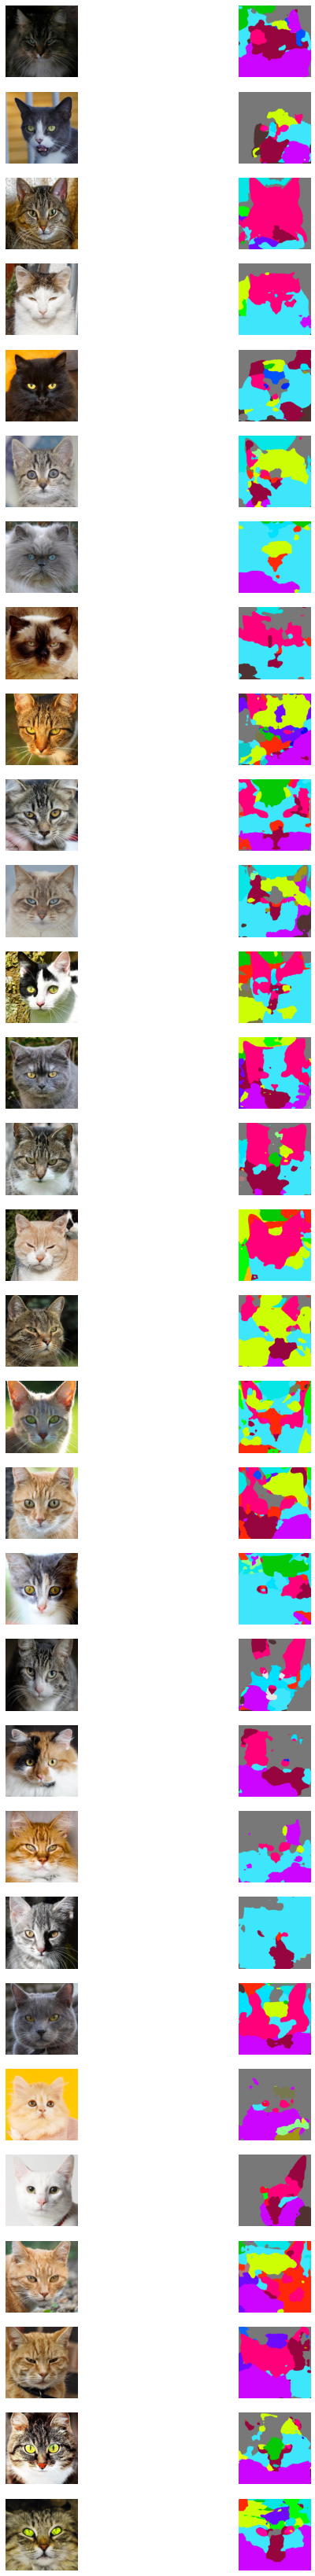

In [38]:
print_images(train_imgs,test_labels, n=30)